In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [2]:
retail = pd.read_csv("OnlineRetail.csv")

In [3]:
retail.columns = retail.columns.str.strip()

In [4]:
# First glance at the data
retail.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# CANCELLATIONS
# If the InvoiceNo starts with the letter 'C', it indicates a cancellation
cancellation_total = retail[retail['InvoiceNo'].str.contains('C')].shape[0]
print(f"Total cancellations: {cancellation_total}")

# Cancellations are not needed for the analysis, so they can be removed
retail = retail[~retail['InvoiceNo'].str.contains('C')]

Total cancellations: 9288


In [6]:
# NEGATIVE QUANTITIES
# Filtering by non-positive Quantity, Description shows manually entered adjustments codes.
negative_quantities = retail[retail['Quantity'] <= 0].groupby(['Description', 'UnitPrice']).size().reset_index(name='count')
negative_quantities = negative_quantities.sort_values(by='count', ascending=False)
print(negative_quantities)

               Description  UnitPrice  count
52                   check        0.0    120
61                 damages        0.0     45
59                 damaged        0.0     42
2                        ?        0.0     41
105  sold as set on dotcom        0.0     20
..                     ...        ...    ...
43              WET/MOULDY        0.0      1
41            Thrown away.        0.0      1
40       Thrown away-rusty        0.0      1
39     Sold as 1 on dotcom        0.0      1
137      wrongly sold sets        0.0      1

[138 rows x 3 columns]


In [7]:
# Remove all rows with non-positive Quantity.
retail = retail[retail['Quantity'] > 0]

In [8]:
# NON-PRODUCT STOCKCODES
# There are a handful of non-product related codes
stc = ['AMAZONFEE', 'BANK CHARGES', 'C2', 'DCGSSBOY', 'DCGSSGIRL',
       'DOT', 'gift_0001_', 'PADS', 'POST']


In [9]:
# Summary
non_product_summary = retail[retail['StockCode'].str.contains('|'.join(stc))].groupby(['StockCode', 'Description']).size().reset_index(name='count')
non_product_summary = non_product_summary.sort_values(by='count', ascending=False)
print(non_product_summary)


       StockCode                          Description  count
7           POST                              POSTAGE   1126
5            DOT                       DOTCOM POSTAGE    708
2             C2                             CARRIAGE    141
4      DCGSSGIRL                      GIRLS PARTY BAG     13
1   BANK CHARGES                         Bank Charges     12
3       DCGSSBOY                       BOYS PARTY BAG     11
9   gift_0001_20   Dotcomgiftshop Gift Voucher £20.00      9
8   gift_0001_10   Dotcomgiftshop Gift Voucher £10.00      8
11  gift_0001_30   Dotcomgiftshop Gift Voucher £30.00      7
6           PADS           PADS TO MATCH ALL CUSHIONS      4
13  gift_0001_50   Dotcomgiftshop Gift Voucher £50.00      4
12  gift_0001_40   Dotcomgiftshop Gift Voucher £40.00      3
0      AMAZONFEE                           AMAZON FEE      2
10  gift_0001_20  to push order througha s stock was       1


In [10]:
# These can all be removed.
retail = retail[~retail['StockCode'].str.contains('|'.join(stc))]

In [11]:
# DESCRIPTION
# Additional adjustment codes to remove
descr = ["check", "check?", "?", "??", "damaged", "found",
         "adjustment", "Amazon", "AMAZON", "amazon adjust",
         "Amazon Adjustment", "amazon sales", "Found", "FOUND",
         "found box", "Found by jackie ", "Found in w/hse", "dotcom",
         "dotcom adjust", "allocate stock for dotcom orders ta", "FBA",
         "Dotcomgiftshop Gift Voucher £100.00", "on cargo order",
         "wrongly sold (22719) barcode", "wrongly marked 23343",
         "dotcomstock", "rcvd be air temp fix for dotcom sit", "Manual",
         "John Lewis", "had been put aside", "for online retail orders",
         "taig adjust", "amazon", "incorrectly credited C550456 see 47",
         "returned", "wrongly coded 20713", "came coded as 20713",
         "add stock to allocate online orders", "Adjust bad debt",
         "alan hodge cant mamage this section", "website fixed",
         "did  a credit  and did not tick ret", "michel oops",
         "incorrectly credited C550456 see 47", "mailout", "test",
         "Sale error",  "Lighthouse Trading zero invc incorr", "SAMPLES",
         "Marked as 23343", "wrongly coded 23343","Adjustment",
         "rcvd be air temp fix for dotcom sit", "Had been put aside."
]

In [12]:
# Filtering out the unwanted entries.
retail = retail[~retail['Description'].isin(descr)]

In [13]:
# There are also some NAs in _Description_.
print(retail['Description'].isna().sum())

584


In [14]:
# Given their small number (around 0.1% of total), I've opted to remove them.
retail = retail.dropna(subset=['Description'])

In [15]:
# CUSTOMER ID
# There is still a significant number of NAs in _CustomerID_.
print(retail['CustomerID'].isna().sum())

131779


In [16]:
# There are almost 5 times as many Orders as there are Customers, so I'm using `InvoiceNo` for orders.
print(retail[['InvoiceNo', 'CustomerID']].nunique())

InvoiceNo     19793
CustomerID     4335
dtype: int64


In [17]:
# Setting 'Description' and 'Country' as factors
retail['Description'] = retail['Description'].astype('category')
retail['Country'] = retail['Country'].astype('category')

In [18]:
# Changing 'InvoiceNo' type to numeric
retail['InvoiceNo'] = pd.to_numeric(retail['InvoiceNo'], errors='coerce')

In [19]:
# Extracting 'Date' and 'Time' from 'InvoiceDate'
retail['Date'] = pd.to_datetime(retail['InvoiceDate']).dt.date
retail['Time'] = pd.to_datetime(retail['InvoiceDate']).dt.strftime("%H:%M:%S")

In [20]:
# Saving cleansed data for analysis phase
retail.to_pickle("retail.pkl")

In [29]:
#For the Assignment
retail = pd.read_csv("OnlineRetail.csv", parse_dates=['InvoiceDate'])

In [30]:
# Extract additional features: Recency, Purchase Time during the day, and Date
current_date = retail['InvoiceDate'].max()
retail['Recency'] = (current_date - retail['InvoiceDate']).dt.days
retail['PurchaseTime'] = retail['InvoiceDate'].dt.hour
retail['PurchaseMonth'] = retail['InvoiceDate'].dt.month

In [60]:
# Main Interface Function for Market Basket Recommender
def RecommendItems(CurItemOfInterest, CustomerID, Country, Time, Date):
    # Filter data based on user input
    recommended_items = retail[(retail['Description'] == CurItemOfInterest) & 
                               (retail['CustomerID'] == CustomerID) & 
                               (retail['Country'] == Country) & 
                               (retail['PurchaseTime'] == Time) & 
                               (retail['PurchaseDate'] == Date)]
    
    return recommended_items['Description'].unique()


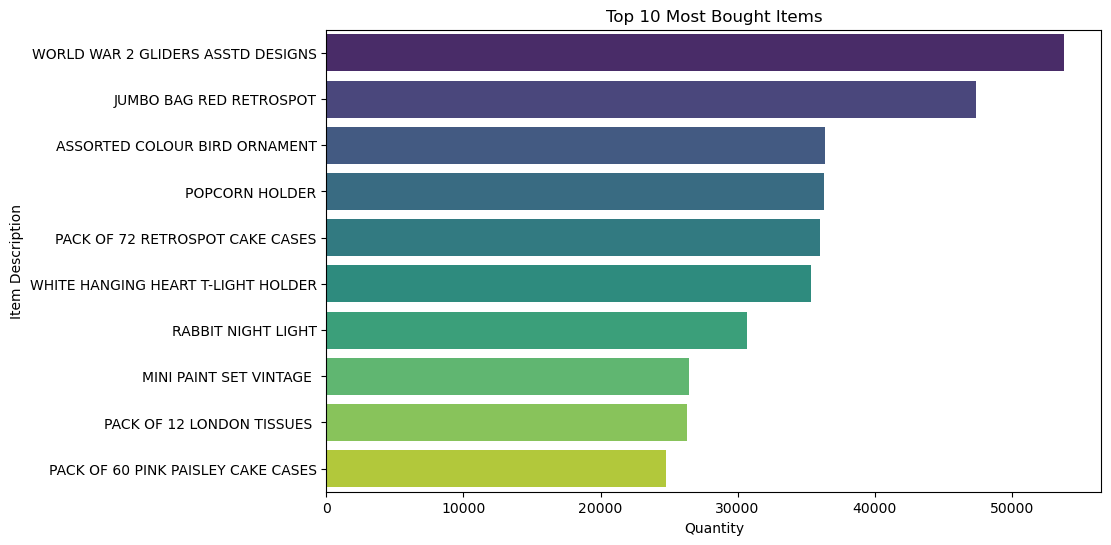

In [32]:
# Visualize and analyze the data

# 1. What items do people buy more often?
top_items = retail.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_items.values, y=top_items.index, palette='viridis')
plt.title('Top 10 Most Bought Items')
plt.xlabel('Quantity')
plt.ylabel('Item Description')
plt.show()

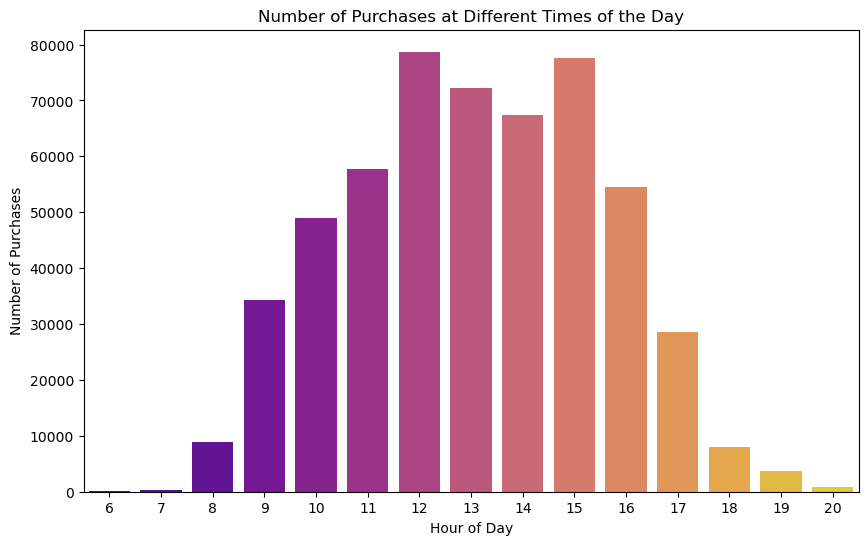

In [33]:
# 2. What time of day do people buy more often?
plt.figure(figsize=(10, 6))
sns.countplot(x='PurchaseTime', data=retail, palette='plasma')
plt.title('Number of Purchases at Different Times of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Purchases')
plt.show()

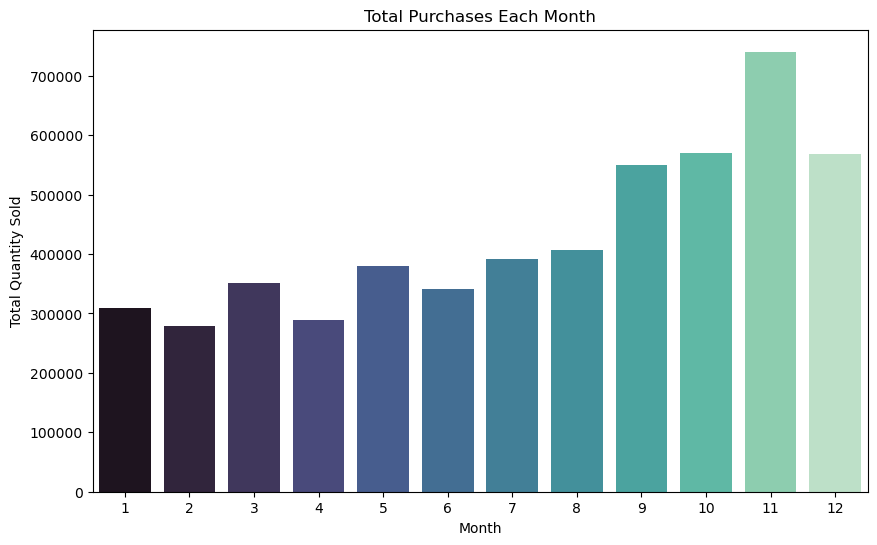

In [34]:
# 3. What month of the year do people buy more often?
monthly_purchases = retail.groupby('PurchaseMonth')['Quantity'].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_purchases.index, y=monthly_purchases.values, palette='mako')
plt.title('Total Purchases Each Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.show()

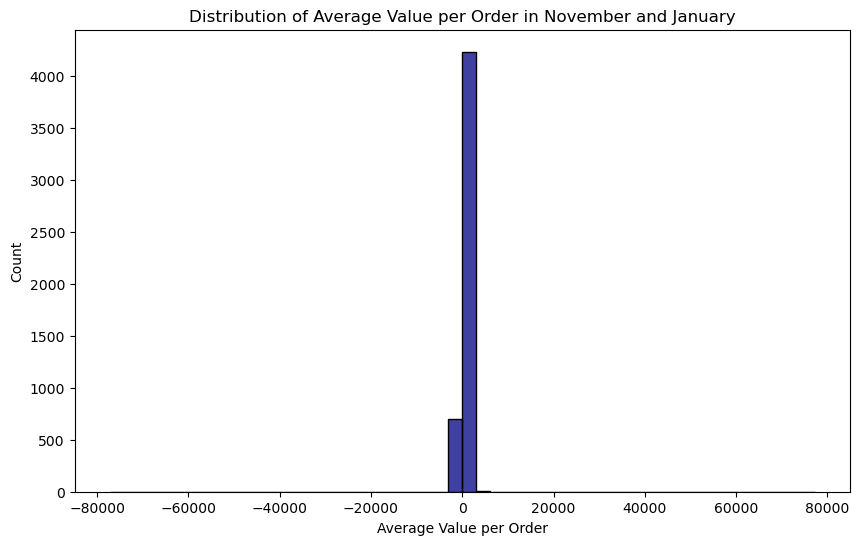

In [37]:
# 4. What is the average value per order during November and January?
retail['Value'] = retail['UnitPrice'] * retail['Quantity']
nov_jan_orders = retail[(retail['PurchaseMonth'] == 11) | (retail['PurchaseMonth'] == 1)]
average_value_per_order = nov_jan_orders.groupby('InvoiceNo')['Value'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_value_per_order, bins=50, color='navy', edgecolor='black')
plt.title('Distribution of Average Value per Order in November and January')
plt.xlabel('Average Value per Order')
plt.ylabel('Count')
plt.show()
